In [1]:
from KoopMPC.RHC_controller import RHC_controller, Condensed_RHC_controller
from KoopMPC.koopman_id import fit_Koopman
from pykoopman.common.examples import vdp_osc, rk4
import numpy as np
import matplotlib.pyplot as plt

# Explicit Embedding Approach

In [2]:
dT = 0.01

In [3]:
# Identification of the approximate Koopman operator
A, B, C, phi = fit_Koopman(dynamics=vdp_osc, n_states=2, n_inputs=1, dT=dT,
                      n_traj=200, n_int=1000)

In [4]:
# Cost parameters
Q = np.eye(2)
R = 1
Pf = Q
N = 20 # Horizon length
M = 1000 # Number of iterations for the simulation

In [5]:
# Constraints
Ex = np.vstack((np.eye(2), -np.eye(2)))
Ef = Ex
Eu = np.vstack((np.eye(1), -np.eye(1)))
ex = np.array([[2], [2], [2], [2]])
ef = ex
eu = np.array([[1], [1]])

In [6]:
# Simulation of the Receding Horizon Control Law
x0 = np.array([[1], [0.5]])
phi0 = phi(x0)
solver = RHC_controller(A, B, C, Q, R, Pf, N, Ex, ex, Eu, eu, Ef, ef)
x1_explicit = np.zeros(M)
x2_explicit = np.zeros(M)
u = np.zeros(M)
for t in range(M):
    x1_explicit[t:t+1] = x0[0:1,:]
    x2_explicit[t:t+1] = x0[1:2,:]
    u_t = solver.solve(phi0)
    u[t] = u_t
    x0 = rk4(0, x0, u_t, dT, vdp_osc)
    phi0 = phi(x0)

[Text(0.5, 0, '$t$'), Text(0, 0.5, '$u(t)$')]

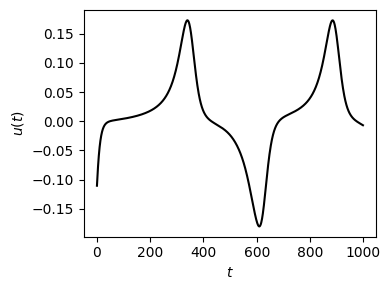

In [7]:
# u plot
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4, 3))
axs.plot(range(M), u, '-k')
axs.set(xlabel=r'$t$', ylabel=r'$u(t)$')

[Text(0.5, 0, '$x_1(t)$'), Text(0, 0.5, '$x_2(t)$')]

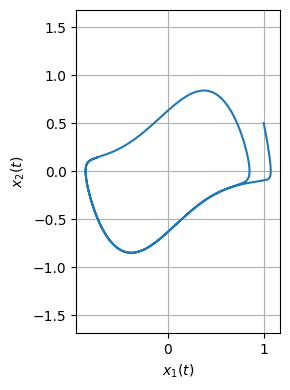

In [8]:
# x plot
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(3, 4))
axs.plot(x1_explicit, x2_explicit)
axs.axis('equal')
axs.grid(True)
axs.set(xlabel=r'$x_1(t)$', ylabel=r'$x_2(t)$')

# Learned Embedding approach

In [9]:
import torch
from NN.nn import HankelNetConv

In [10]:
nn = HankelNetConv(n=2, n_prime=7, m=1, N=20, hidden_dim=[64, 64, 32])
nn.load_state_dict(torch.load('./NN/model.pth'))
nn.eval()
L, G = nn.get_L(), nn.get_G()
phi = nn.phi

torch.Size([2, 1])


In [11]:
# Simulation of the Receding Horizon Control Law
N = 20
x0 = np.array([[1], [0.5]])
phi0 = phi(torch.from_numpy(x0).float().T).detach().numpy().T
solver = Condensed_RHC_controller(L, G, Q, R, Pf, Ex, ex, Eu, eu, Ef, ef, N=N)
x1_learned = np.zeros(M)
x2_learned = np.zeros(M)
u = np.zeros(M)
for t in range(M):
    x1_learned[t:t+1] = x0[0:1,:]
    x2_learned[t:t+1] = x0[1:2,:]
    u_t = solver.solve(phi0)
    u[t] = u_t
    x0 = rk4(0, x0, u_t, dT, vdp_osc)
    phi0 = phi(torch.from_numpy(x0).float().T).detach().numpy().T

[Text(0.5, 0, '$t$'), Text(0, 0.5, '$u(t)$')]

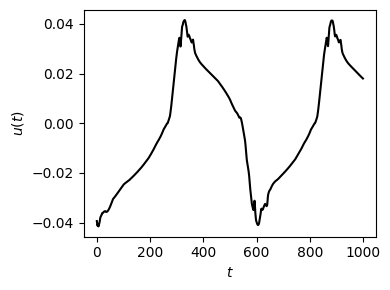

In [12]:
# u plot
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4, 3))
axs.plot(range(M), u, '-k')
axs.set(xlabel=r'$t$', ylabel=r'$u(t)$')

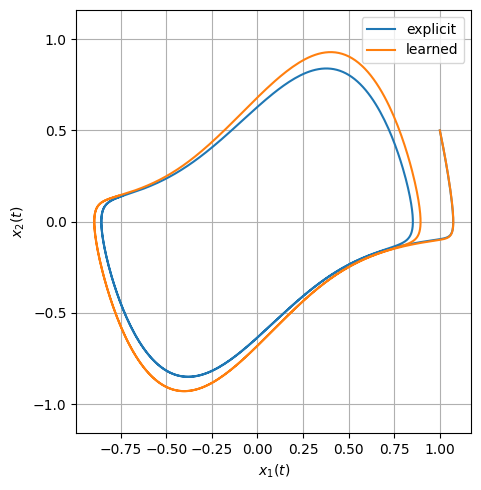

In [13]:
# x plot
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(5, 5))
axs.plot(x1_explicit, x2_explicit, label="explicit")
axs.plot(x1_learned, x2_learned, label="learned")
axs.axis('equal')
axs.grid(True)
axs.set(xlabel=r'$x_1(t)$', ylabel=r'$x_2(t)$')
axs.legend()

# Uncontrolled Evolution

In [14]:
# Simulation of the Receding Horizon Control Law
N = 20
x0 = np.array([[1], [0.5]])
x1_uncontrolled = np.zeros(M)
x2_uncontrolled = np.zeros(M)
for t in range(M):
    x1_uncontrolled[t:t+1] = x0[0:1,:]
    x2_uncontrolled[t:t+1] = x0[1:2,:]
    x0 = rk4(0, x0, 0, dT, vdp_osc)

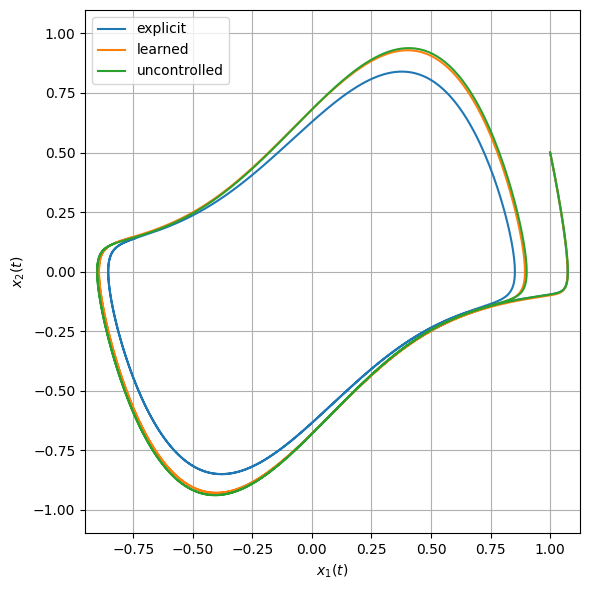

In [15]:
# x plot
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
axs.plot(x1_explicit, x2_explicit, label="explicit")
axs.plot(x1_learned, x2_learned, label="learned")
axs.plot(x1_uncontrolled, x2_uncontrolled, label="uncontrolled")
axs.axis('equal')
axs.grid(True)
axs.set(xlabel=r'$x_1(t)$', ylabel=r'$x_2(t)$')
axs.legend()